# Probability estimation for an LSTM network with Platt Scaling

Sindelar, L. (2020). *Time Series and Confidence Analysis for Remaining Useful Lifetime*. Unpublished Master's Thesis, Bielefeld University.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras import callbacks
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras import optimizers

# Collection for data import and evaluation functions
from util import *

## Scenario:

An airplane company is investigating the lifetime of their jet engines to optimise their maintenance process.

The company collected data from previously run enginges. The sensors are queried in intervals and inlcude:
* temperatures
* pressures
* ratios (e.g. of fuel to air)
* ...

The machine learning model is trained to estimate whether an engine will fail in the next $w$ intervals(cycles). 

$$
\begin{align}
c(x) &=\begin{cases}
			1 &, \text{RUL}(x) \le w\\
			0 &, \text{else}
			\end{cases}
\end{align}$$


We use the NASA [Turbofan data set](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan) for the purpose of this scenario. 

To feed the data into the model, sequences with a set length were created overlappingly using a sliding window.
For example, let's assume we want a sequence length of 3. Then a series of length 10 is cut into 8 sequences of length 3 (see run A below). However, if the series is shorter than the sequence length, it is disregarded (see run B below).

![sequences](img/sequences.png)



#### Splitting the data:
Furthermore, we split the training data into a training and a validation data set. The validation data set is then used for the Platt scaling to prevent unwanted bias.


In [2]:
# Assumes data is labeled as follows:
# train_FD001.txt
# test_FD001.txt
# RUL_FD001.txt
data_path = "data/"
data_idx = 1

# Define that all columns are used for training
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting_1', 'setting_2', 'setting_3', 'time_norm']
sequence_cols.extend(sensor_cols)

# Load data
data = CMAPSS_Data(data_path=data_path)
train_df, test_df = data.load_data(data_idx, w=30, preprocess="std")

# Create sequences
seq_dict = data.create_sequences(train_df, test_df, 'label_1', sequence_cols,
                                 val_ratio=0.4, sequence_length=50, save=False)
# Training set sequences
seq_array =seq_dict['train_seq']
label_array =seq_dict['train_label']
# Validation set sequences
seq_array_val =seq_dict['val_seq']
time_array_val =seq_dict['val_time']
label_array_val =seq_dict['val_label']
# Test set sequences
seq_array_test =seq_dict['test_seq']
time_array_test =seq_dict['test_time']
label_array_test =seq_dict['test_label']

## The Model

In this notebook we use an LSTM network. LSTM networks offer good reliability on time series data. The keras implementation also supports sequences as input.

We are use the following structure:

![lstm](img/lstm.png)

In [3]:
# define model parameters
sequence_length = 50
batch_size = 200
epochs = 100
model_path = 'model/its_ml_model_'+ str(data_idx) + '.h5'

# Derive input and output dimensions
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

# Create the model
model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

print(model.summary())

# Fit the network
selected_callbacks = [callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                      callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]

history = model.fit(seq_array, label_array, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=0,
          callbacks= selected_callbacks)

# list all data in history
print(history.history.keys())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           50400     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
____________________________________________________

## Platt Scaling

Platt scaling is a method for probability estimation for non-probabilistic models by Platt (1999). It was originally developed for the SVM, but is also applicable for artificial neural networks like the LSTM (see Niculescu-Mizil and Caruana, 2005). It takes the raw model output and fits it to a sigmoid function. This sigmoid function can then be used for the estimation of class probabilities.


$\DeclareMathOperator*{\argmin}{arg\,min}$
Minimise the negative log likelihood of the training data ($f_i, y_i$) for the parameters of the sigmoid function $A$ and $B$:

$$
\argmin\limits_{A, B} - \sum_{i} y_i log(p_i) + (1 - y_i) log(1 - p_i)
$$

where the probability $p_i$ is defined by the sigmoid function:
$$
p_i = \frac{1}{1 + exp(A f_i + B)}
$$

For the LSTM network we use the second to last layer as input for the Platt scaling.

Line search fails (stepsize: 8.881784197001252e-16)
Sigmoid A=[-6.5709147], B=[4.137352]


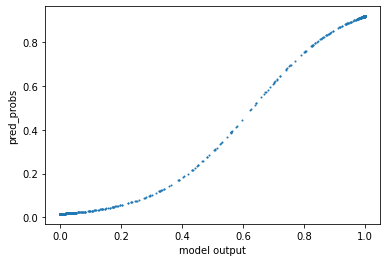

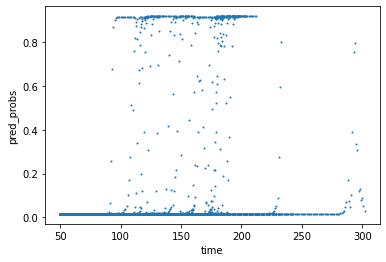

In [4]:
# layer data function
intermediate_layer_model = Model(inputs=model.input,
                                     outputs=model.get_layer(index=5).output)

clf_out = intermediate_layer_model.predict(seq_array_val)

# Apply Platt scaling

target = label_array_val
prior_1 = np.count_nonzero(target)
prior_0 = target.shape[0] - prior_1

# The line search often fails, but still produces a good result
A, B = newton_platt(clf_out, target, prior_1, prior_0, minstep=1e-15)

# Use Platt scaling for test set
test_clf_out = intermediate_layer_model.predict(seq_array_test)
pred_probs = predict_platt_probs(A, B, test_clf_out)
print("Sigmoid A={}, B={}".format(A, B))

plt.scatter(test_clf_out, pred_probs, s=1)
plt.ylabel('pred_probs')
plt.xlabel('model output')
plt.show()

plt.scatter(time_array_test, pred_probs, s=1)
plt.ylabel('pred_probs')
plt.xlabel('time')
plt.show()

## Result:

In the first plot we can see the training of a sigmoid to the model output was successful. The sigmoid shapes of the second plot are shifted, because the sigmoid output is plotted against the time and not the model output.

With the estimated probabilities we get an idea of how the certain an engine failure is for each model output. The estimation for each time step is less precise, since the time series vary in length. This can be used in further steps to make decisions about maintainance schedules and other decisions.


## Evaluation

Now it has to be looked into how well the model performes. 

In [5]:
evaluate_lstm(model, seq_array, label_array, title='Training', verbose=True)

evaluate_lstm(model, seq_array_test, label_array_test, title='Test', verbose=True)


 === Training === 

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[7497   36]
 [  34 1826]]
tp: 1826, fp: 36, tn: 7497, fn: 34
 Accuracy:  0.993 
 Precision:  0.981 
 Recall:  0.982 
 F1-score: 0.981 
 AUROC-score: 0.988

 === Test === 

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[7733   98]
 [  67  265]]
tp: 265, fp: 98, tn: 7733, fn: 67
 Accuracy:  0.98 
 Precision:  0.73 
 Recall:  0.798 
 F1-score: 0.763 
 AUROC-score: 0.893


(7733, 98, 67, 265, 0.98, 0.73, 0.798, 0.763, 0.893)

## References
* C-MAPSS data set: [data set](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan) and [publication](https://ti.arc.nasa.gov/m/pub-archive/154/154_Saxena.pdf)
* Based on code by [Umberto Griffo](https://github.com/umbertogriffo/Predictive-Maintenance-using-LSTM)

## Literature:
* Saxena et al. "Damage propagation modeling for aircraft engine run-to-failure simulation". In: 2008 International Conference on Prognostics and Health Management (2008).
* Platt. "Probabilistic outputs for support vector machines and comparisons to regularized likelihood methods". In: ADVANCES IN LARGE MARGIN CLASSIFIERS (1999).
* Niculescu-Mizil and Caruana. "Predicting Good Probabilities With Supervised Learning". In: ICML 05: Proceedings of the 22nd international conference on Machine learning (2005).
